In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Define Pools and Algorithms

In [2]:
pools = ['Pool_49', 'Pool_52', 'Pool_60']
algorithms = ['DeepNovo', 'PEAKS', 'Novor','DirecTag']
alg_file = ['deepnovo', 'peaks', 'novor','direcTag']

RESULT_DIR = '../../../Data/Analysis_new/'

### Load the data of the experiment (all spectra), the parsed algorithm results and the scores algorithms results

In [3]:
experiment_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        raw_data =pd.read_csv(
            f"../../../Data/Datasets/{p}/Thermo_SRM_{p}_01_01_3xHCD-1h-R2-tryptic/msmsScans.txt",
            sep='\t', index_col=None)
        pool_dict[alg] = raw_data [['Scan number', 'Identified', 'Sequence']]
    experiment_data_dict[p] = pool_dict



In [4]:
parsed_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        parsed_data = pd.read_csv(f'../../../Data/ParsingResults/{p}/{file}_results_all_sequences.tsv', sep='\t', index_col=None)
        pool_dict[alg] = parsed_data
    parsed_data_dict[p] = pool_dict



In [5]:
scored_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        file = file+'_scored'
        if file == 'direcTag_scored':
            file = file + '_grouped'
            
        identified_maxquant = pd.read_csv(f'../../../Data/ScoringResults/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_maxquant['by'] = 'MaxQuant'
        identified_inclusion_list= pd.read_csv(f'../../../Data/ScoringResults_Unidentified/CheckInclusionList/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_inclusion_list['by'] = 'InclusionList'
        pool_dict[alg] = pd.concat([identified_maxquant, identified_inclusion_list], axis=0)
    scored_data_dict[p] = pool_dict

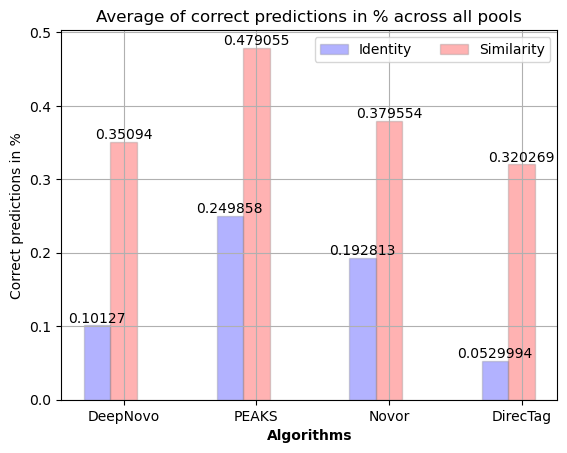

In [15]:
avg_identity = []
avg_similarity = []

fig, ax = plt.subplots()
plt.grid()
barWidth = 0.2

for alg in algorithms:
    absolute_dict = []
    relative_dict = []
    # create grouped bar plot

    similarity_100_dict = {}
    identity_100_dict = {}
    
    for i, p in enumerate(pools):
        experiment_df = experiment_data_dict[p][alg]
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        # create bar plot
        
        total = experiment_df.shape[0]
        identified_maxquant = experiment_df.query('Identified == \'+\'').shape[0]
        predicted = parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique()
        identified_alg = scored_df.shape[0]

        similarity_100_dict[p] = scored_df.query('Similarity == 1.0').shape[0]/predicted
        identity_100_dict[p] = scored_df.query('Identity == 1.0').shape[0]/predicted

    avg_identity.append(sum(identity_100_dict.values())/len(identity_100_dict.values()))
    avg_similarity.append(sum(similarity_100_dict.values())/len(similarity_100_dict.values()))

bars1_1 = avg_identity
bars2 = avg_similarity

# create bar plot
plt.title(f'Average of correct predictions in % across all pools')
barWidth = 0.2
r1 = range(len(bars1_1))
r2 = [x + barWidth for x in r1]
plt.bar_label(plt.bar(r1, bars1_1, color='b', width=barWidth, edgecolor='grey', label='Identity', alpha=0.3))
plt.bar_label(plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Similarity', alpha=0.3))
plt.xlabel('Algorithms', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1_1))], algorithms)
plt.legend(loc='best', ncols=2)
plt.ylabel('Correct predictions in %')
plt.savefig(f'{RESULT_DIR}average_correct_predictions.png')
plt.show()
    


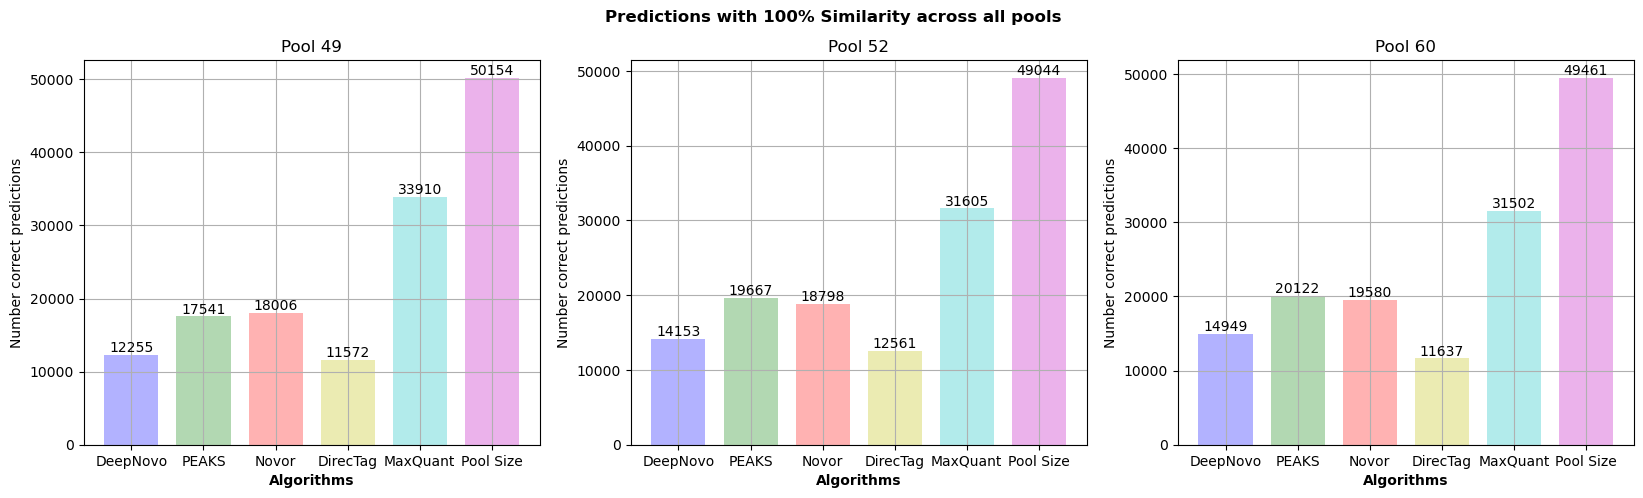

In [58]:
avg_identity = []
avg_similarity = []

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
barWidth = 0.75

pool_size = []
maxquant_identified = []
predctions_by_alg = {
    'DeepNovo': [],
    'PEAKS': [],
    'Novor': [],
    'DirecTag': []
}
identified_by_alg = {
    'DeepNovo': [],
    'PEAKS': [],
    'Novor': [],
    'DirecTag': []
}
for i, p in enumerate(pools):
    labels = ['DeepNovo', 'PEAKS', 'Novor', 'DirecTag', 'MaxQuant', 'Pool Size']
    values_pred = []
    values_id = []

    for alg in algorithms:
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        values_pred.append(parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique())
        values_id.append(scored_df.query('Similarity == 1.0').shape[0])

    raw_df = experiment_data_dict[p]
    values_pred.append(raw_df['DeepNovo'].query('Identified == \'+\'').shape[0])
    values_id.append(raw_df['DeepNovo'].query('Identified == \'+\'').shape[0])
    values_pred.append(raw_df['DeepNovo'].shape[0])
    values_id.append(raw_df['DeepNovo'].shape[0])

    bar_color = ['b', 'g', 'r', 'y', 'c', 'm']

    ax[i].bar_label(ax[i].bar(labels, values_id, width=barWidth, label=labels, alpha=0.3, color=bar_color))



    ax[i].set_xlabel('Algorithms', fontweight='bold')
    ax[i].grid()
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    #ax[i].legend(loc='best', ncols=2)
    ax[i].set_ylabel('Number correct predictions')

fig.suptitle(f'Predictions with 100% Similarity across all pools', fontweight='semibold')
plt.savefig(f'{RESULT_DIR}number_of_identified_spectra.png')
fig.show()



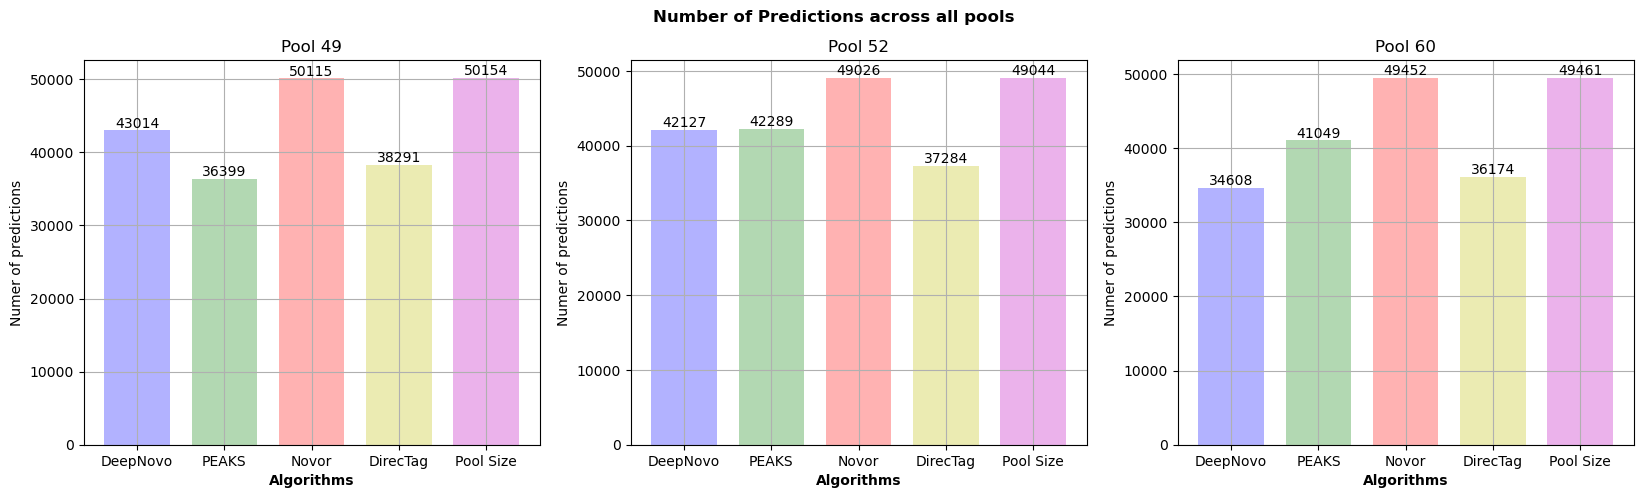

In [54]:
avg_identity = []
avg_similarity = []

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
barWidth = 0.75

pool_size = []
maxquant_identified = []
predctions_by_alg = {
    'DeepNovo': [],
    'PEAKS': [],
    'Novor': [],
    'DirecTag': []
}
identified_by_alg = {
    'DeepNovo': [],
    'PEAKS': [],
    'Novor': [],
    'DirecTag': []
}
for i, p in enumerate(pools):
    labels = ['DeepNovo', 'PEAKS', 'Novor', 'DirecTag', 'Pool Size']
    values_pred = []
    values_id = []

    for alg in algorithms:
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        values_pred.append(parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique())
        values_id.append(scored_df.query('Similarity == 1.0').shape[0])

    raw_df = experiment_data_dict[p]
    values_pred.append(raw_df['DeepNovo'].shape[0])
    values_id.append(raw_df['DeepNovo'].shape[0])

    bar_color = ['b', 'g', 'r', 'y', 'm']

    ax[i].bar_label(ax[i].bar(labels, values_pred, width=barWidth, label=labels, alpha=0.3, color=bar_color))



    ax[i].set_xlabel('Algorithms', fontweight='bold')
    ax[i].grid()
    ax[i].set_title(f"{' '.join(p.split('_'))}")
    #ax[i].legend(loc='best', ncols=2)
    ax[i].set_ylabel('Numer of predictions')

fig.suptitle(f'Number of Predictions across all pools',fontweight='semibold')
plt.savefig(f'{RESULT_DIR}number_of_predictions.png')
fig.show()

